# Bagging for data valuation

This notebook introduces the Data-OOB method, an implementation based on a publication from Kwon and Zou "Data-OOB: Out-of-bag Estimate as a Simple and Efficient Data Value" ICML 2023 , using pyDVL.
https://proceedings.mlr.press/v202/kwon23e.html

The objective of this paper is mainly to overcome the computational bottleneck of shapley-based data valuation methods that require to fit a significant number of models to accurately estimate marginal contributions.
The algorithms computes data values from out of bag estimates using a bagging model.

The value can be interpreted as a partition of the OOB estimate, which is originally introduced to estimate the prediction error. This OOB estimate is given as:

$$
\sum_{i=1}^n\frac{\sum_{b=1}^{B}\mathbb{1}(w_{bi}=0)T(y_i, \hat{f}_b(x_i))}{\sum_{b=1}^{B}
\mathbb{1}
(w_{bi}=0)}
$$


## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate (including most plotting code) has been omitted for convenience.

</div>

In [1]:
%load_ext autoreload

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pydvl.value import compute_data_oob
from pydvl.utils import Dataset, Utility, Scorer
from pydvl.reporting.scores import compute_removal_score
from pydvl.reporting.plots import shaded_mean_std, plot_best_worst, plot_best_worst_class_imbalance, compute_best_worst_scores, plot_methods_linreg
from pydvl.value.result import ValuationResult

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [3]:

from sklearn.datasets import load_iris, fetch_kddcup99, fetch_openml
import pandas as pd

In [4]:
import pandas as pd
from sklearn.datasets import load_iris

data = Dataset.from_sklearn(load_iris())

In [5]:

#model = KNeighborsClassifier(n_neighbors=5)
model = DecisionTreeClassifier(max_depth=5,)
#model = LogisticRegression()
utility = Utility(model, data, Scorer("f1", default=0.0))

# Varying Objective scorer

> :warning: This is useless as oob does not rely on the scorer. It relies on point wise error metrics.  :warning:

In [6]:
def oob_func(utility, scorer_name):
    
    return(compute_data_oob(Utility(utility.model, utility.data, Scorer(scorer_name)), n_est=30, max_samples=0.6, progress=False))
scorer_name_list = ["accuracy"]#, "f1", "roc_auc", "balanced_accuracy","neg_log_loss"]
func = oob_func
kwargs_list = [{"scorer_name":scorer_name} for scorer_name in scorer_name_list]

roc_auc_ovo_weighted


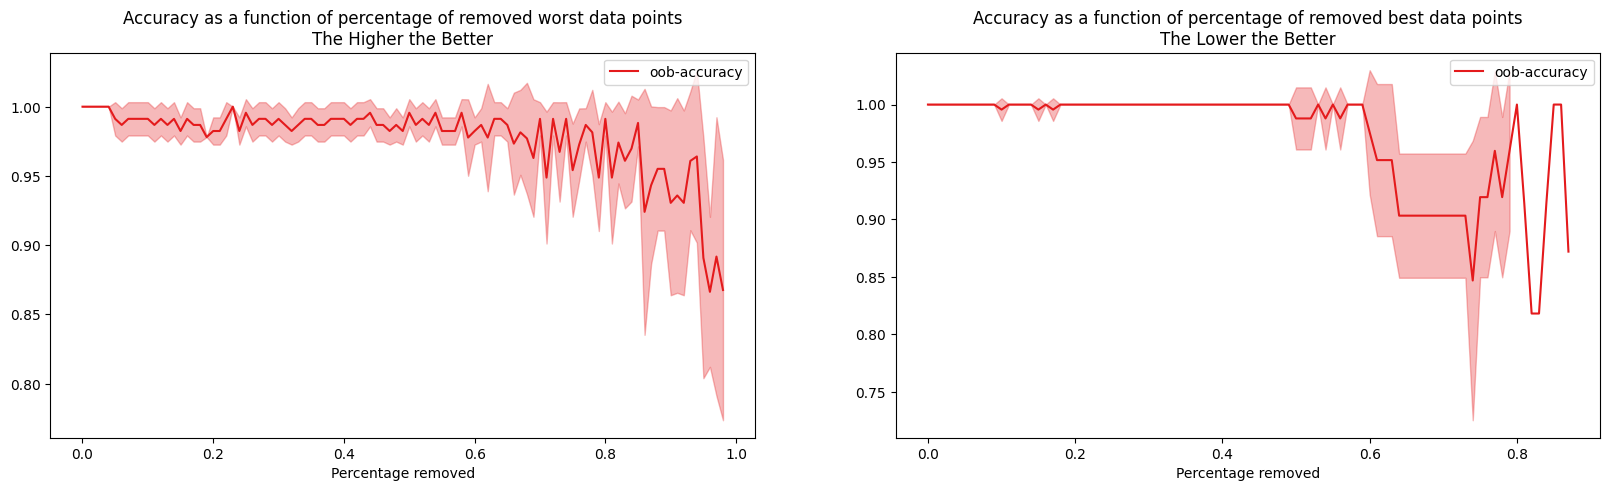

accuracy


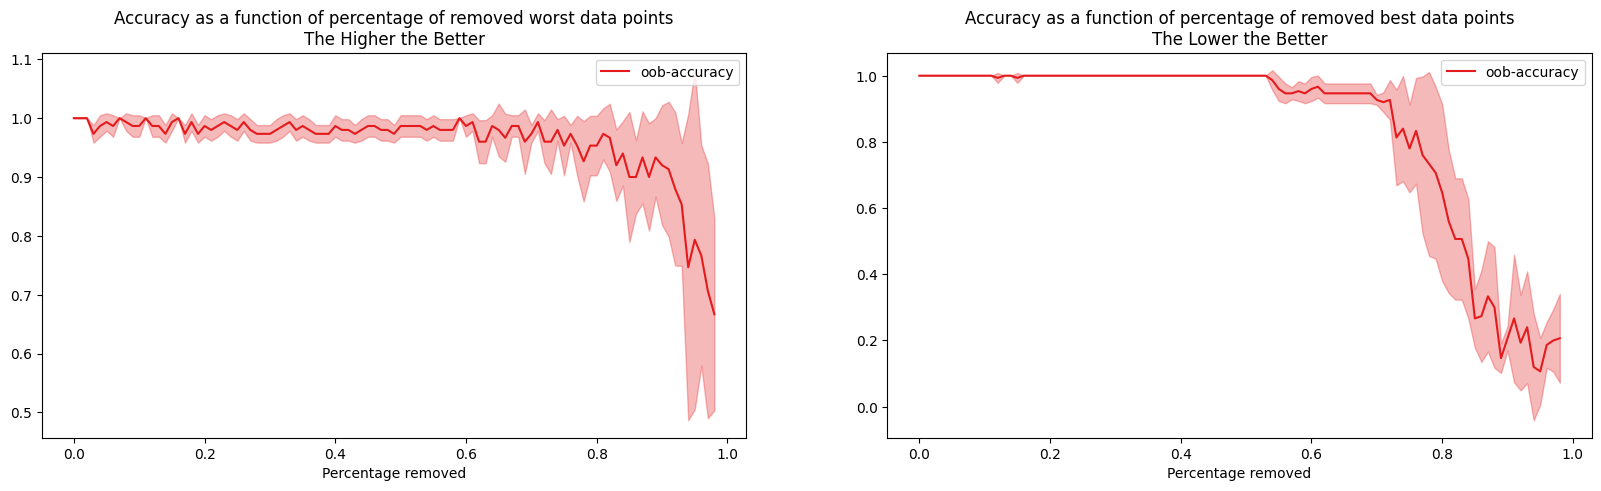

balanced_accuracy


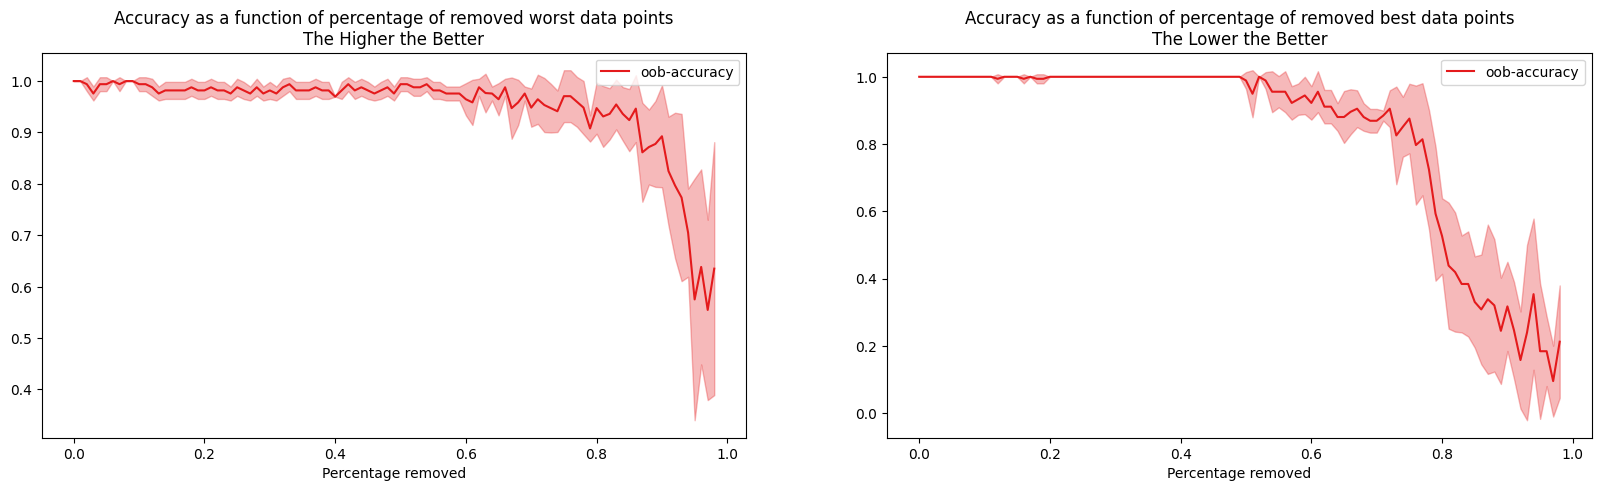

neg_log_loss


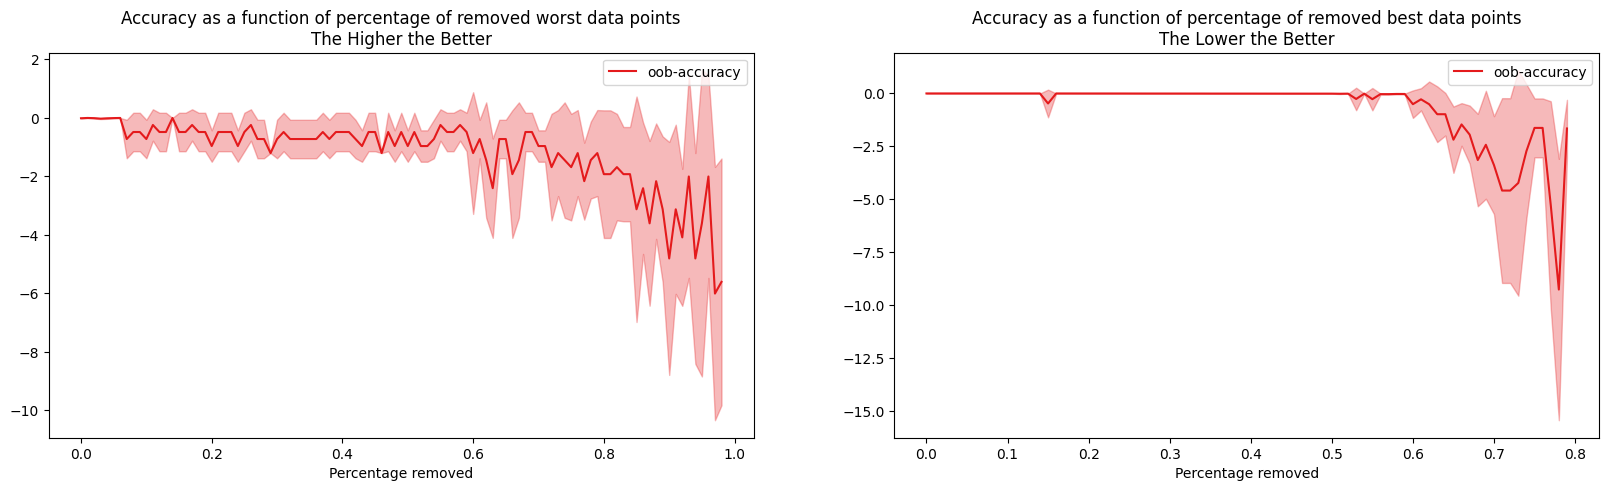

In [7]:
model_eval = DecisionTreeClassifier(max_depth=3)
for m in  ["roc_auc_ovo_weighted","accuracy",  "balanced_accuracy","neg_log_loss"]:#,  "f1", "roc_auc", "recall","jaccard","neg_brier_score","average_precision"
    print(m)
    utility_eval = Utility(model_eval, data, Scorer(m))
    n_iter = 5
    removal_percentages = np.arange(0, 0.99, 0.01)
    best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, removal_percentages, n_iter, oob_func, kwargs_list,f_name="oob-", return_values=True)
    plot_best_worst(best_scores_df, worst_scores_df, palette_name="Set1")

# Varying cardinality

# Varying number of estimators

In [8]:
def oob_func(utility, n_est):
    return(compute_data_oob(utility, n_est=n_est, max_samples=0.6, progress=False))
n_est_list = [20,30, 50, 100, 1000]
func = oob_func
kwargs_list = [{"n_est":n_est} for n_est in n_est_list]

In [9]:

model_eval = DecisionTreeClassifier(max_depth=3)
utility_eval = Utility(model_eval, data, Scorer("accuracy", default=0.0))
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.01)
best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, removal_percentages, n_iter, oob_func, kwargs_list, return_values=True)

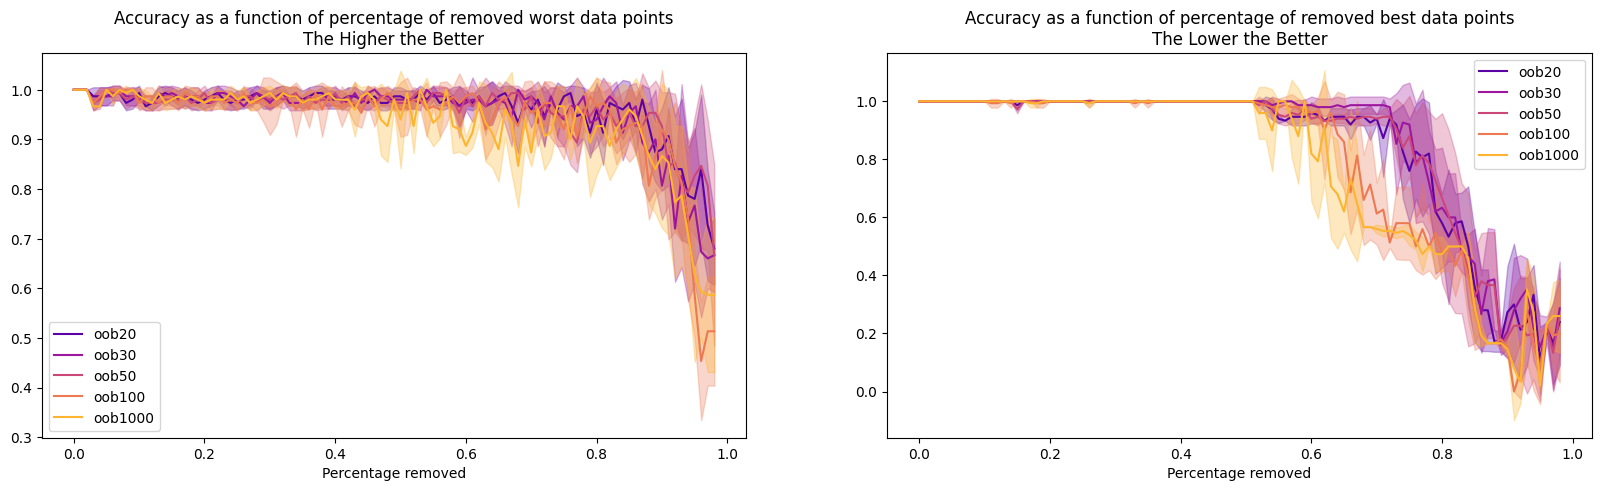

In [10]:
plot_best_worst(best_scores_df, worst_scores_df, palette_name="plasma")

In [15]:
best_scores_df[best_scores_df.method_name=="oob_20"]

,0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,...,0.9,0.91,0.92,0.93,0.9400000000000001,0.9500000000000001,0.96,0.97,0.98,method_name
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.133333,0.400000,0.000000,0.066667,0.166667,0.033333,0.200000,0.000000,0.233333,oob_20
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.533333,0.566667,0.466667,0.400000,0.400000,0.233333,0.233333,0.366667,0.366667,oob_20
10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.233333,0.233333,0.133333,0.166667,0.400000,0.033333,0.233333,0.200000,0.233333,oob_20
15,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.166667,0.000000,0.166667,0.166667,0.400000,0.000000,0.200000,0.200000,0.000000,oob_20
20,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.300000,0.300000,0.300000,0.400000,0.300000,0.233333,0.233333,0.066667,0.366667,oob_20


In [27]:

random_best = []
random_worst = []
random_vals = []
n_iter=3
for i in range(n_iter):
    vals = ValuationResult.from_random(size=len(utility_eval.data))
    random_vals.append(vals)
    best_score  = compute_removal_score(
                                            u=utility_eval,
                                            values=vals,
                                            percentages=removal_percentages,
                                            remove_best=True,
                                        )
    random_best.append(best_score)
    worst_score  = compute_removal_score(
                                            u=utility_eval,
                                            values=vals,
                                            percentages=removal_percentages,
                                            remove_best=False,
                                        )
    random_worst.append(worst_score)


In [28]:
pd.DataFrame(random_list)

,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,...,0.89,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.800000,0.800000,0.800000,0.900000,0.700000,0.800000,0.933333,0.833333,0.900000,0.800000
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.866667,0.866667,0.866667,0.466667
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.833333,0.833333,0.633333,0.833333,0.833333,0.633333,0.833333,0.500000,0.466667,0.466667


AttributeError: 'dict' object has no attribute 'shape'

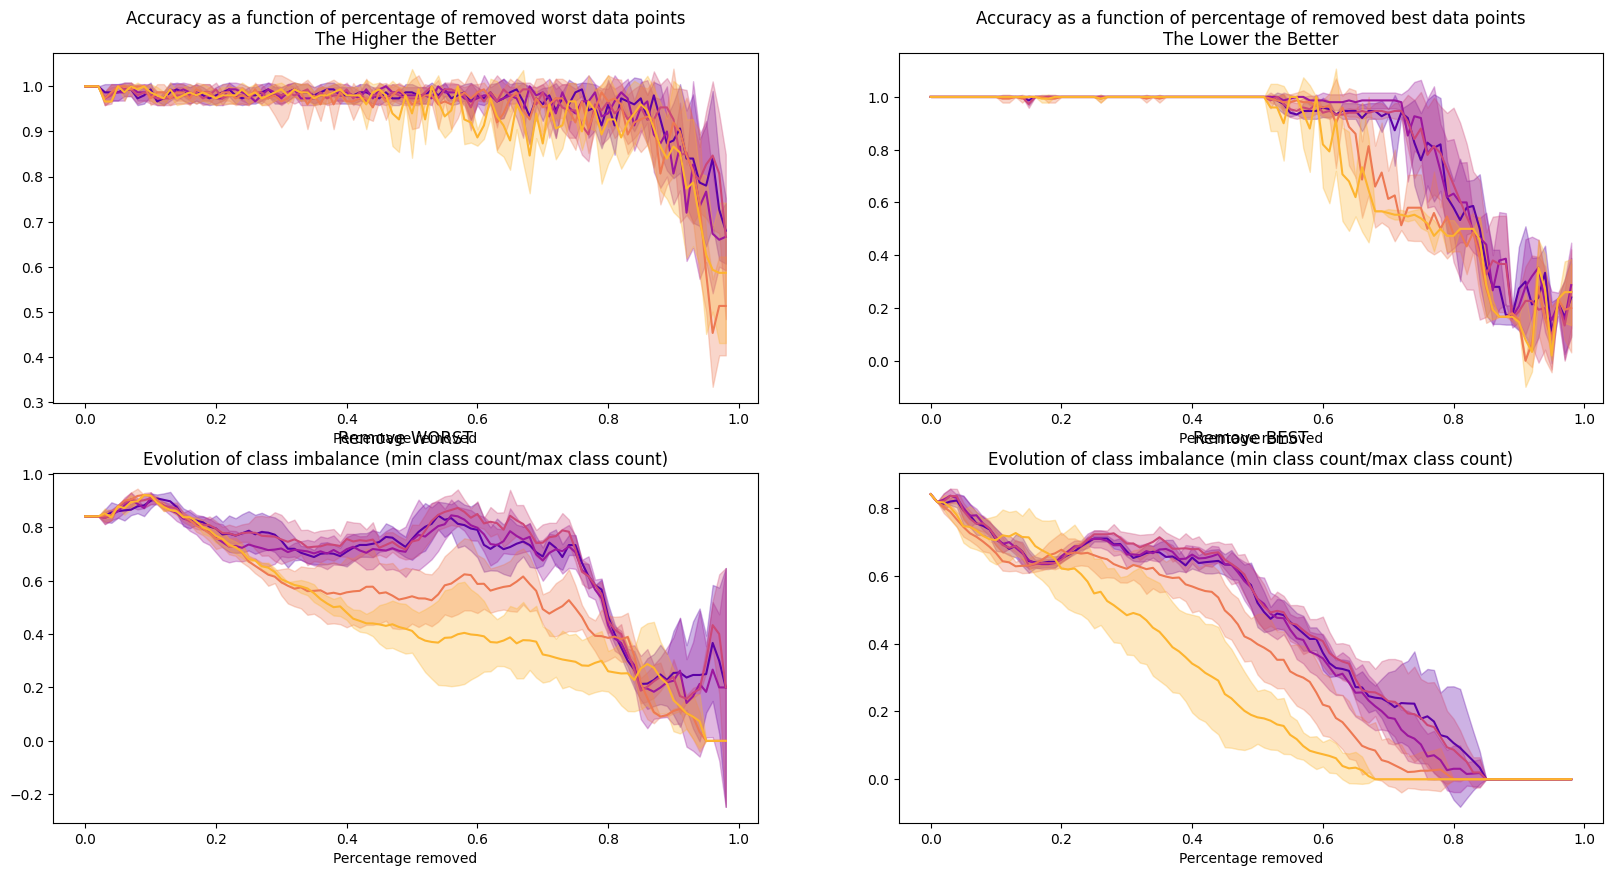

In [12]:
plot_best_worst_class_imbalance(best_scores_df, worst_scores_df, all_values, utility_eval, palette_name="plasma", random_run=True)

# Max_samples

In [ ]:
def oob_func(utility, max_samples):
    return(compute_data_oob(utility, n_est=30, max_samples=max_samples, progress=False))
max_samples_list = [x/10 for x in range(1,9,1)]
func = oob_func
kwargs_list = [{"max_samples":max_samp} for max_samp in max_samples_list]


In [ ]:
model_eval = DecisionTreeClassifier(max_depth=3)
utility_eval = Utility(model_eval, data, Scorer("accuracy", default=0.0))
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.01)
best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, removal_percentages, n_iter, oob_func, kwargs_list, return_values=True)

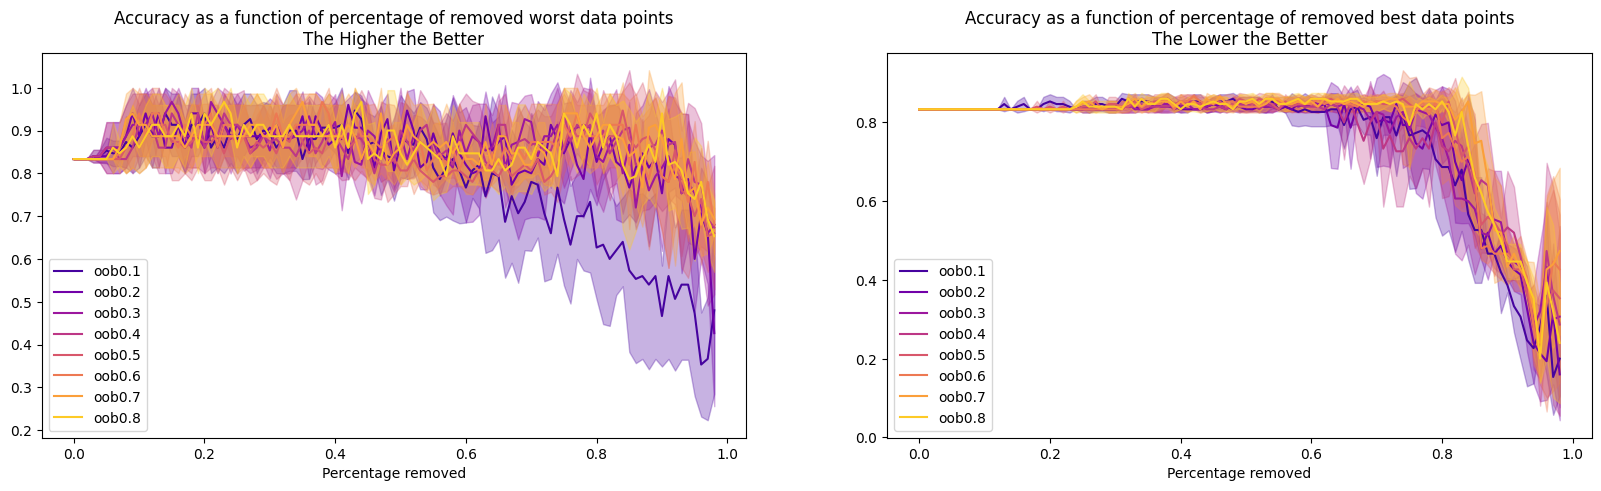

In [ ]:
plot_best_worst(best_scores_df, worst_scores_df, palette_name="plasma")feature encoding and standardization internally.
loader = GenericDataLoader(


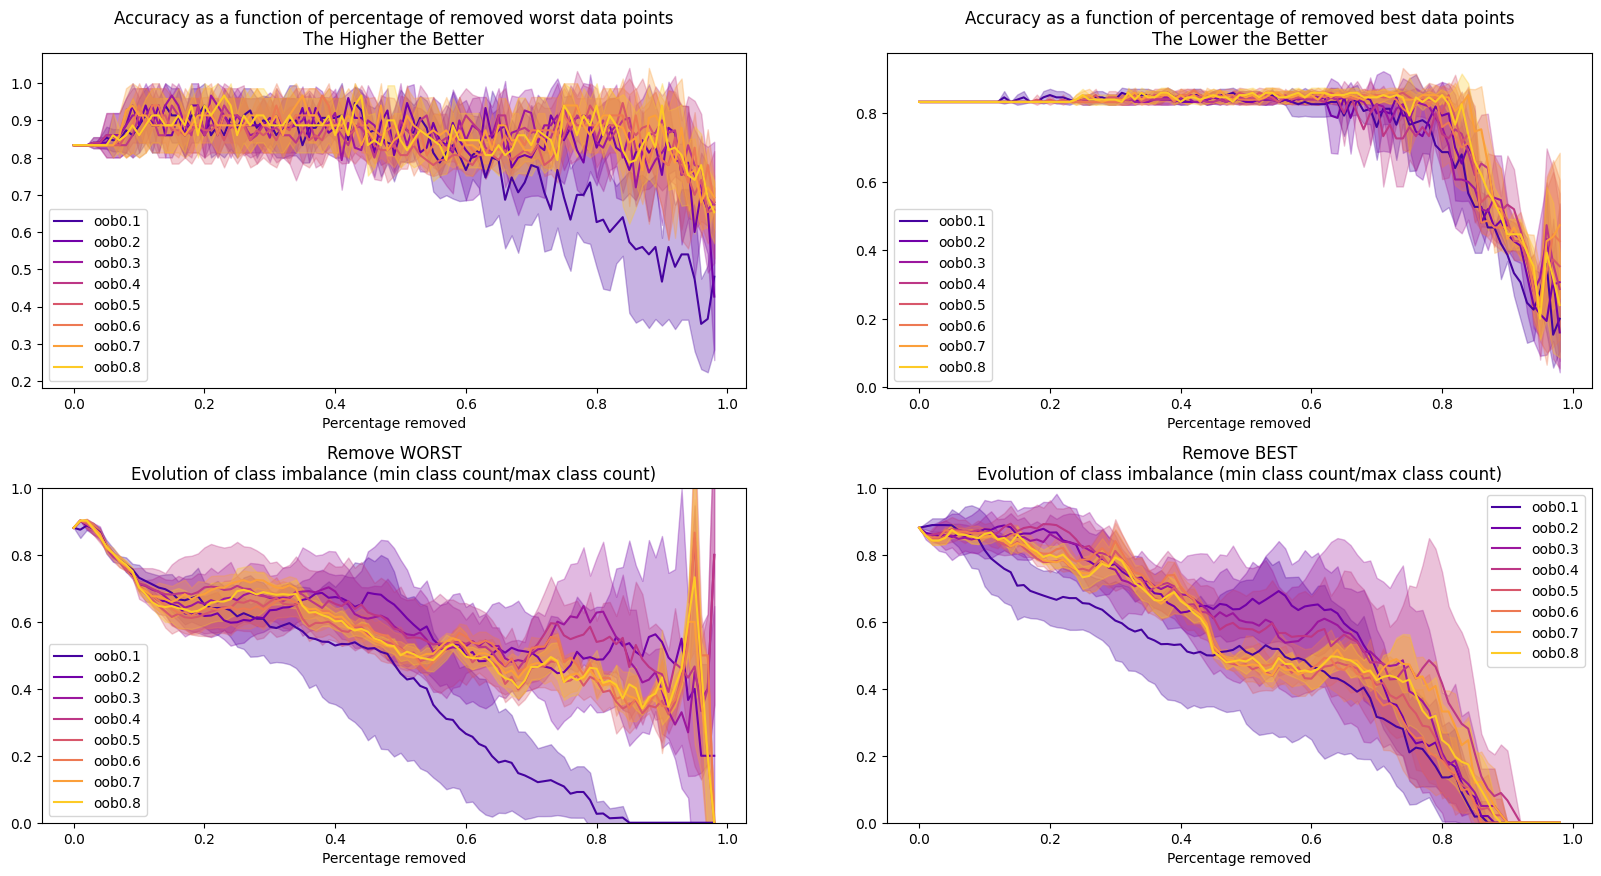

In [ ]:
plot_best_worst_class_imbalance(best_scores_df, worst_scores_df, all_values, utility_eval, palette_name="plasma")

# Base estimator

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process.kernels import RBF

In [ ]:

model = KNeighborsClassifier(n_neighbors=5)
model = DecisionTreeClassifier(max_depth=2,)
model = LogisticRegression()
scorer = Scorer("accuracy", default=0.0)
dict_utilities = {}
utility = Utility(KNeighborsClassifier(n_neighbors=5), data, scorer)
dict_utilities["KNN"] = utility
utility = Utility(DecisionTreeClassifier(max_depth=2,), data, scorer)
dict_utilities["DecisionTreeShallow"] = utility
utility = Utility(DecisionTreeClassifier(max_depth=20,), data, scorer)
dict_utilities["DecisionTreeDeep"] = utility
#utility = Utility(GaussianProcessClassifier(1.0 * RBF(1.0)), data, scorer)
#dict_utilities["GaussianProcess"] = utility
#utility = Utility(GaussianNB(), data, scorer)
#dict_utilities["GaussianNB"] = utility
#utility = Utility(MLPClassifier(), data, scorer)
#dict_utilities["MLPClassifier"] = utility
utility = Utility(RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), data, scorer)
dict_utilities["RandomForest"] = utility
utility = Utility(AdaBoostClassifier(), data, scorer)
dict_utilities["AdaBoost"] = utility
#utility_lr = Utility(LogisticRegression(), data, scorer)
#dict_utilities["KNN"] = utility_knn
utility = Utility(LGBMClassifier(verbose= -1), data, scorer)
dict_utilities["LGBM"] = utility

dict_utilities.keys()

dict_keys(['KNN', 'DecisionTreeShallow', 'DecisionTreeDeep', 'RandomForest', 'AdaBoost', 'LGBM'])

In [ ]:
list(dict_utilities.keys())

['KNN',
 'DecisionTreeShallow',
 'DecisionTreeDeep',
 'RandomForest',
 'AdaBoost',
 'LGBM']

In [ ]:
def oob_func(utility, model_name):
    return(compute_data_oob(dict_utilities[model_name], n_est=30, max_samples=0.8, progress=False))
max_samples_list = np.arange(0.1,0.90,0.1)
func = oob_func
kwargs_list = [{"model_name":m} for m in dict_utilities.keys()]

In [ ]:
model_eval = DecisionTreeClassifier(max_depth=3)
utility_eval = Utility(model_eval, data, Scorer("accuracy", default=0.0))
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.01)
best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, removal_percentages, n_iter, oob_func, kwargs_list, return_values=True)

In [ ]:
best_scores_df

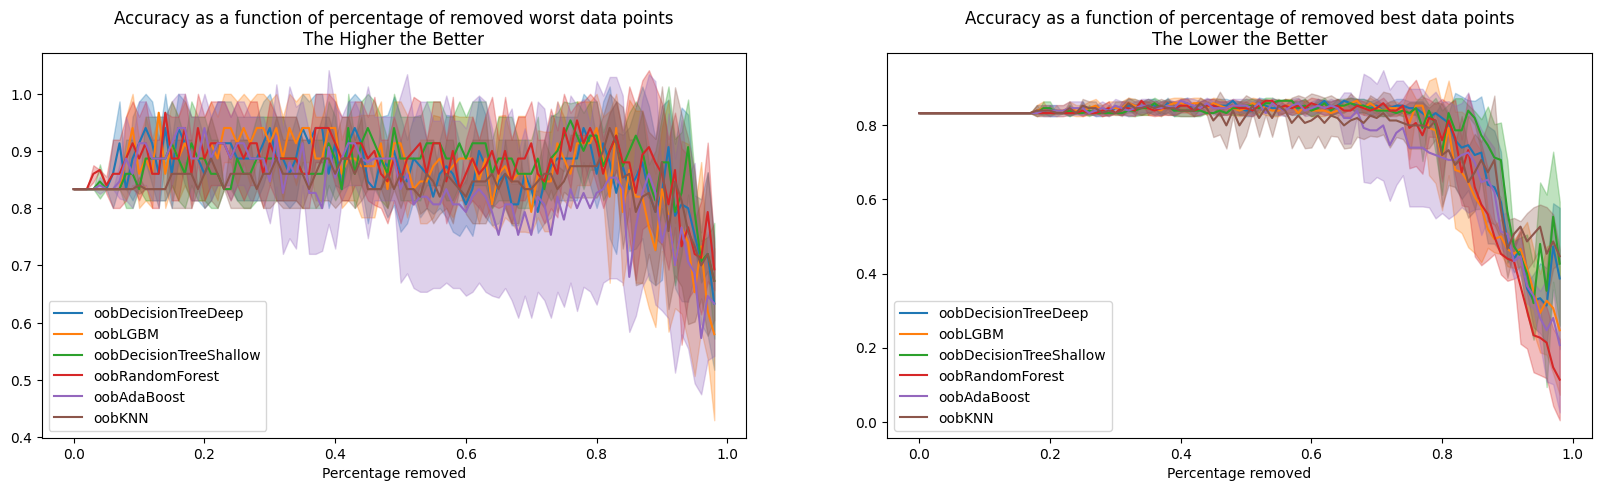

In [ ]:
plot_best_worst(best_scores_df, worst_scores_df, palette_name="tab10")

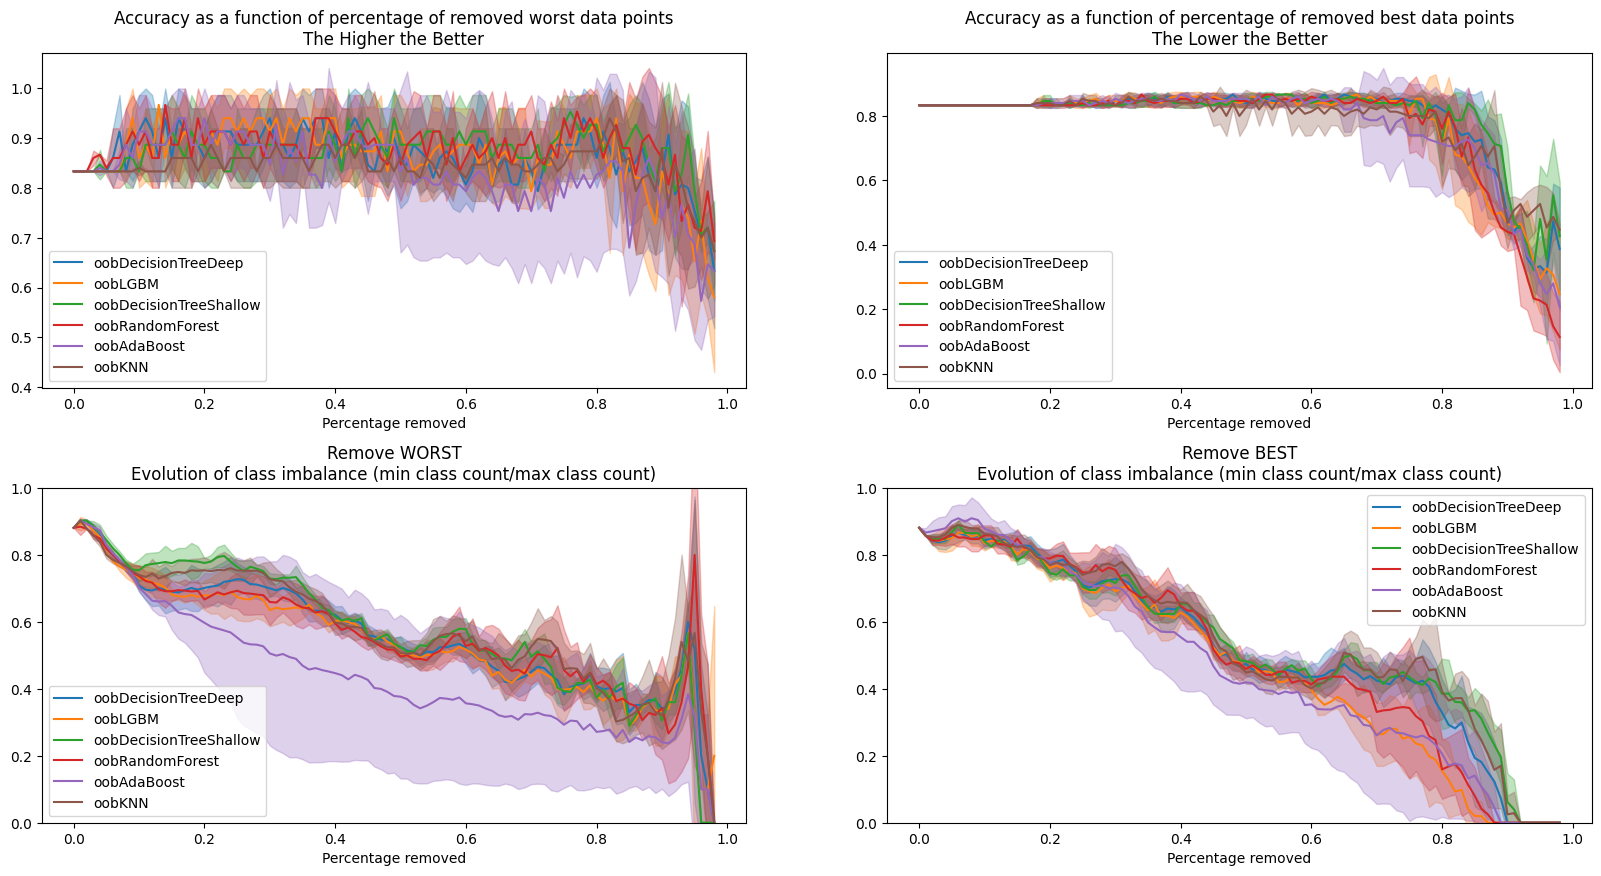

In [ ]:
plot_best_worst_class_imbalance(best_scores_df, worst_scores_df, all_values, utility_eval, palette_name="tab10")

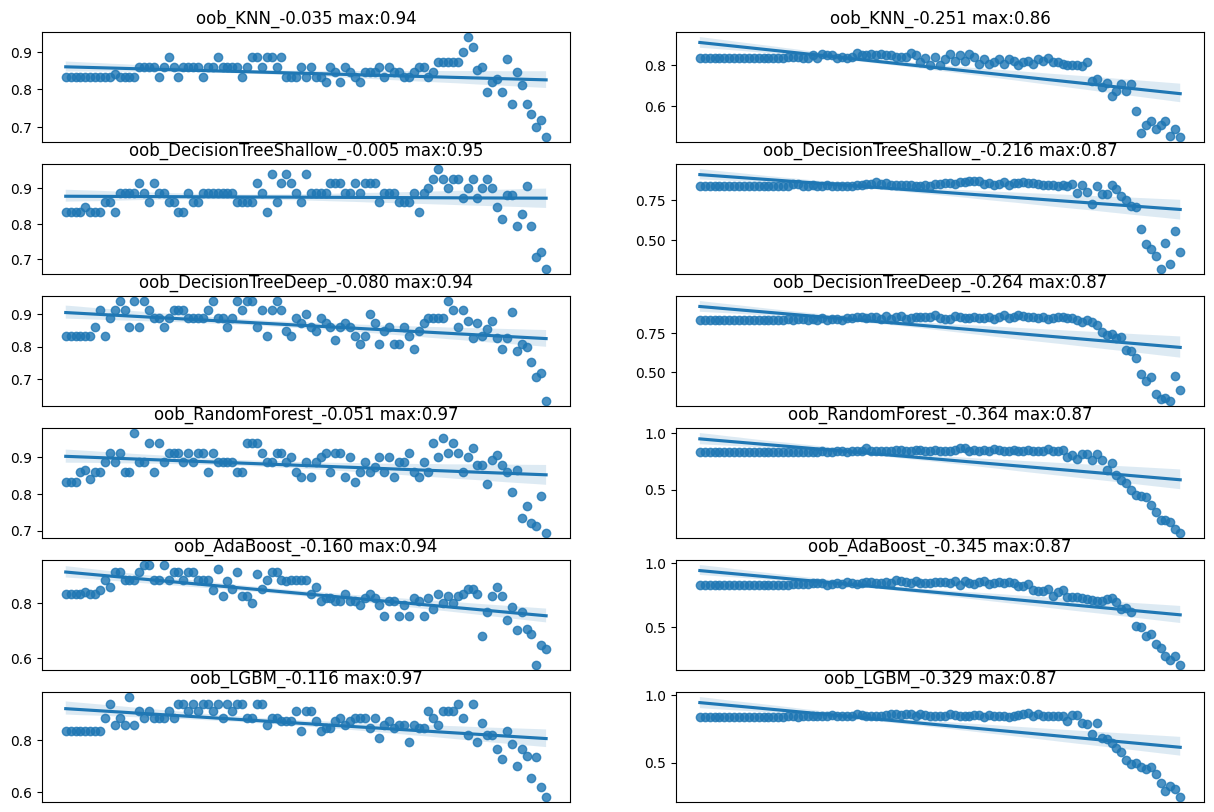

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=best_scores_df.method_name.nunique(), figsize = [15,10])
for i, x in enumerate(best_scores_df.method_name.unique()):
    p=sns.regplot(x=np.arange(len(best_scores_df.groupby("method_name").mean().values[i])), y =best_scores_df.groupby("method_name").mean().loc[x].values, ax=ax[i,1])
    y_data = p.get_lines()[0].get_ydata()
    maxi = best_scores_df.groupby("method_name").mean().loc[x].max()
    ax[i,1].set_title(f"{x}_{y_data[-1]-y_data[0]:.3f} max:{maxi:.2f}")
    ax[i,1].set_xticks([])
    p=sns.regplot(x=np.arange(len(worst_scores_df.groupby("method_name").mean().values[i])), y =worst_scores_df.groupby("method_name").mean().loc[x].values, ax=ax[i,0])
    y_data = p.get_lines()[0].get_ydata()
    maxi = worst_scores_df.groupby("method_name").mean().loc[x].max()
    ax[i,0].set_title(f"{x}_{y_data[-1]-y_data[0]:.3f} max:{maxi:.2f}")
    ax[i,0].set_xticks([])